# What do people from Reddit say about used cars?
### An analysis of text data scraped from Reddit posts and comments


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa, pyarrow.parquet as pq, pyarrow.compute as pc
from chatwhatcartobuy.utils.getpath import get_repo_root

## Parsing the scraped data

In [2]:
# Create a parquet dataset object to merge all parquet files from respective dataset directory
root = get_repo_root()
sub_dataset = pq.ParquetDataset(root / 'data/raw/submission-dataset')
com_dataset = pq.ParquetDataset(root / 'data/raw/comment-dataset')

In [3]:
# Convert to PyArrow table, then to Pandas dataframe
sub_df = sub_dataset.read().to_pandas()
com_df = com_dataset.read().to_pandas()

In [4]:
print(f'Submission Dataframe shape: {sub_df.shape}')
print(f'Comment Dataframe shape: {com_df.shape}')

Submission Dataframe shape: (5299, 8)
Comment Dataframe shape: (331854, 6)


## Understanding the data

Descriptive statistics offer a quick and convenient way to diagnose the condition of the data and determine the presence of outliers. In the case of Reddit submissions and comments, it's normal for the data to exhibit a prominent left skew due to the vast majority of submissions and comments having low-moderate upvotes, and a few viral posts or comments to have several thousands of votes.

__Numeric Data: Score (Upvotes), Upvote Ratio, Number of Comments__

In [5]:
sub_df.describe()

,score,upvote_ratio,timestamp,num_comments
count,5299.0,5299.0,5299,5299.0
mean,218.561993,0.809851,2023-12-08 05:09:31,127.109643
min,0.0,0.09,2011-01-10 22:20:36,0.0
25%,1.0,0.68,2023-08-09 23:00:59,7.0
50%,4.0,0.87,2024-10-22 20:09:08,31.0
75%,78.5,0.99,2025-04-10 06:59:33,133.0
max,23944.0,1.0,2025-07-16 06:14:36,3676.0
std,896.35101,0.198649,NaN,260.084068


The comments show a surprising minimum value with 105 downvotes. This begs the question of whether downvoted comments should be retained or removed from the dataset, given the potential implications of heavily downvoted comments (e.g. misleading, irrelevant, or malicious). However, it's also worth noting the irrationality of social media users where even a single disagreement can immediately result in a negatively scored comment (since most comments in reddit have either 0 or 1 starting score).

In [6]:
com_df.describe()

,score,timestamp
count,331854.0,331854
mean,10.163897,2024-01-19 15:16:21
min,-105.0,2011-01-10 22:32:42
25%,1.0,2023-09-27 05:38:09
50%,1.0,2024-08-16 02:18:30
75%,2.0,2025-03-09 00:59:38
max,8363.0,2025-07-16 06:54:25
std,74.334446,NaN


From the information below, the median score of downvoted comments is -2, and the 3rd quantile is -1, which shows that the vast majority of downvoted comments can't immediately be ruled out as misleading, malicious, or irrelevant--and may stem from simple disagreements online. It's worth noting, however, that comments with scores below the 25th percentile may warrant being filtered out. Still, this requires human judgement and a detailed reading of a sample of heavily downvoted comments.

In [7]:
com_df[com_df.score < 0].score.describe()

count      6767.0
mean    -4.154426
std      6.660018
min        -105.0
25%          -5.0
50%          -2.0
75%          -1.0
max          -1.0
Name: score, dtype: double[pyarrow]

Character counts and token counts are crucial in tuning the ETL pipeline, particularly the data transformation and filtering process where I implemented a short text filter based on an arbitrarily low number of characters for each respective text data type (i.e. title, selftext, body). An unbiased way to tune the transformer would be to perform this analysis on raw, unfiltered data; however, the current filtering seems sufficient (and may even require a higher minimum character count as the minimum submission title and comment body token counts are extremely low). Further processing can be done during analysis and model-building to address the lapses of the basic transformations from the ETL pipeline.

__Text Data: ASCII Character Count and Token Counts__

In [8]:
# Convert text data to character length
sub_char_len = pd.DataFrame(
    zip(sub_df.title.map(lambda row: len(row)),
        sub_df.selftext.map(lambda row: len(row))
        ), 
    columns=['title_len', 'selftext_len']
    )
print('Submission ASCII Character Count:\n', sub_char_len.describe())

Submission ASCII Character Count:
          title_len  selftext_len
count  5299.000000   5299.000000
mean     63.464805   1631.714286
std      39.783522   2703.454568
min      15.000000     55.000000
25%      36.000000    499.000000
50%      55.000000    908.000000
75%      77.000000   1673.500000
max     300.000000  38038.000000


In [9]:
com_char_len = com_df[['body']].map(lambda row: len(row))
print('Comment ASCII Character Count:\n', com_char_len.describe())

Comment ASCII Character Count:
                 body
count  331854.000000
mean      265.046888
std       348.281932
min         3.000000
25%        74.000000
50%       157.000000
75%       322.000000
max      9706.000000


In [10]:
sub_tok_count = pd.DataFrame(
    zip(sub_df.title.str.count(r'(\b\w+\b)'),
        sub_df.selftext.str.count(r'(\b\w+\b)')
        ), 
    columns=['title', 'selftext']
    )
print('Submission Token Count:\n', sub_tok_count.describe())

Submission Token Count:
              title     selftext
count  5299.000000  5299.000000
mean     12.297226   313.622004
std       7.836197   507.362178
min       2.000000    10.000000
25%       7.000000    98.500000
50%      11.000000   178.000000
75%      15.000000   326.000000
max      65.000000  7091.000000


The token count from below shows a surprising minimum value of 0, which should have been addressed in the ETL pipeline during the transform step where null or empty text records should have been filtered out from the corpora. Upon checking, there were some comments that only contained uninformative punctuations, which were retained during the transform step in the ETL. Regardless, the usual NLP libraries such as spacy, nltk, scikit-learn, and even encoder-decoders have robust tokenization processes that perform stopword removal, punctuation removal, and other appropriate treatments to tame text data.

In [11]:
# Just to retain column header; but can be as simple as com_df.body.str.count(<pat>).describe()
com_tok_count = com_df[['body']].apply(lambda col: col.str.count(r'(\b\w+\b)'))
print('Comment Token Count:\n', com_tok_count.describe())

Comment Token Count:
             body
count   331854.0
mean   51.627646
std    66.649372
min          0.0
25%         15.0
50%         31.0
75%         63.0
max       1838.0


In [12]:
# Show the records with 0 token counts
print(com_df.body[com_df.body.str.count(r'\b\w+\b') == 0])

107137         !)
186468         !)
208134     , , . 
289667         !)
Name: body, dtype: string


## Data wrangling

__Removing duplicates__

The results below show multiple duplicate comments. Although the ETL pipeline handles deduplication, cleaning, and other naive transformations on the text data, since it exports batched data, it's possible for duplicates to reoccur upon merging the separate batch files when loading the parquet data files. 

Increasing the buffer size for the Data Loader can potentially mitigate the amount of duplicates at the cost of memory and file export frequency, however it doesn't scale well with larger volumes of data. For the sake of simplicity, I will still perform deduplication after parsing parquet files. 

In [13]:
# Number of duplicated submissions by submission ID
sub_df.duplicated().sum()

np.int64(1143)

In [14]:
# Number of duplicated comments by comment ID
com_df.duplicated('comment_id').sum()

np.int64(225158)

In [15]:
# Show the sample duplicated comments
np.random.seed(42)
sample_duplicated_comment_id = np.random.choice(com_df[com_df.duplicated('comment_id')].comment_id)
com_df.query('comment_id == @sample_duplicated_comment_id')

,comment_id,body,score,timestamp,subreddit,parent_submission_id
121958,h448sw1,really interesting writeup! enjoy your car and...,6,2021-07-05 10:57:07,r/cars,oe2408
201289,h448sw1,really interesting writeup! enjoy your car and...,6,2021-07-05 10:57:07,r/cars,oe2408
304444,h448sw1,really interesting writeup! enjoy your car and...,5,2021-07-05 10:57:07,r/cars,oe2408


In [16]:
# Remove duplicated comments
sub_df_clean = sub_df.drop_duplicates('submission_id')
com_df_clean = com_df.drop_duplicates('comment_id')
print(f'Shape of deduplicated submission dataframe: {sub_df_clean.shape}')
print(f'Shape of deduplicated comment dataframe: {com_df_clean.shape}')

Shape of deduplicated submission dataframe: (2818, 8)
Shape of deduplicated comment dataframe: (106696, 6)


__Removing empty records (without words)__

It's possible that certain records are retained because they are non-empty, but not necessarily filled with actual words. For instance, a particular records can be made up of only punctuations or non-word characters after applying the transformations from the ETL pipeline. To remove these edge cases, I simply masked the dataframe by the records that have non-zero word counts, where a word is defined as an ASCII character enclosed by word boundaries.

In [17]:
# Remove the records with 0 token counts
print('Before removing non-token records from comments: ', com_df_clean.shape)
 
# Only retain records with non zero token counts
com_df_clean = com_df_clean.loc[com_df.body.str.count(r'\b\w+\b') > 0]
print('After removing non-token records from comments: ', com_df_clean.shape)

Before removing non-token records from comments:  (106696, 6)
After removing non-token records from comments:  (106694, 6)


In [18]:
# Remove the records with 0 token counts
print('Before removing non-token records from submissions: ', sub_df_clean.shape)

# Only retain records with non zero token counts for both title and selftext
sub_df_clean = sub_df_clean.loc[(sub_df_clean.title.str.count(r'\b\w+\b') > 0)
                                & (sub_df_clean.selftext.str.count(r'\b\w+\b') > 0)]
print('After removing non-token records from submissions: ', sub_df_clean.shape)

Before removing non-token records from submissions:  (2818, 8)
After removing non-token records from submissions:  (2818, 8)


__Filtering by post and comment score__

From the samples below, nothing seems out of the ordinary for the lightly downvoted comments. Some may be uninformative short liners, yet can still be retained for simple sentiment analysis. On the other hand, heavily downvoted comments may be emotionally charged, controversial, or simply considered inappropriate by a considerable number of users, which led to the low score. 

For this application, I will exclude heavily downvoted comments and posts as I simply want to obtain the recommendations agreed upon by the vast majority of users in Reddit. Although some of these downvoted comments may contain informative content that may simply be bitter pills to swallow, the context of this application requires me to go along with the agreed-upon sentiment by most people.

In [19]:
# Sampling the heavily and lightly downvoted comments
## Lightly downvoted comments
lightly_downvoted_comments = com_df_clean.body[(com_df_clean.score >= -2) & (com_df_clean.score < 0)]
rand_idx = np.random.choice(lightly_downvoted_comments.index, size=5)
for com in lightly_downvoted_comments[rand_idx]:
    print(com)

*cream of the crop
actually some budget tyres are better performing (safety/grip) than premiums. think there was a top gear on it years ago. one of the reason is premium tyres are designed to last longer, as that s one of the premium benefits. but this means using a harder compound, which will last longer, but isn t going to grip as well as a softer compound. there was a reasonably scientific assessment, not just clarkson going powwwwer.
lmao that's what you get.
i think something like this ticks every box. comfortable, reliable, reputable brand, 60+ mpg, 35 tax, euro 6 and automatic. [https://www.autotrader.co.uk/car-details/202310022568151?sort=relevance&advertising-location=at\_cars&annual-tax-cars=to\_35&exclude-writeoff-categories=on&fuel-consumption=over\_50&fuel-type=diesel&keywords=euro%206&make=seat&maximum-mileage=60000&model=leon&postcode=ts43eg&price-to=15000&radius=300&transmission=automatic&fromsra](https://www.autotrader.co.uk/car-details/202310022568151?sort=relevance&a

In [20]:
## Heavily downvoted comments
heavily_downvoted_comments = com_df_clean.body[com_df_clean.score < -2]
rand_idx = np.random.choice(heavily_downvoted_comments.index, size=5)
for com in heavily_downvoted_comments[rand_idx]:
    print(com)

your journey? nobody gives two fucks about your journey
with 2 teens i think my 2024 rav4 prime xse is a cool vehicle. it can do 0-60 in 5.5 seconds and that is only 2 seconds slower than a hellcat yet is more efficient than a prius.
you can t sell a car with a loan on it privately
their dct is not a dct, and it's not theirs. it's a zf8 trans, that's used in many many cars from bmw, jeep, supra, etc. edit: oops, i was wrong! zf8 was rumored but not actually launched with, the c8 has a tremec tr-9080. sometimes the zf8 trans is mistakenly called a dct
no thanks, i'm good. $200/wk fuel tarted up landcruiser is the 'best' option on that list. second best is the bmw because it has the b58 engine, shame it's going to waste its life like that.


__Removing heavily downvoted posts and comments__

In [21]:
print('Before removing heavily downvoted comments: ', com_df_clean.shape)
com_df_clean = com_df_clean[com_df_clean.score >= -2]
print('After removing heavily downvoted comments: ', com_df_clean.shape)

Before removing heavily downvoted comments:  (106694, 6)
After removing heavily downvoted comments:  (105773, 6)


In [22]:
print('Before removing heavily downvoted posts: ', sub_df_clean.shape)
sub_df_clean = sub_df_clean[sub_df_clean.score >= -2]
print('After removing heavily downvoted posts: ', sub_df_clean.shape)

Before removing heavily downvoted posts:  (2818, 8)
After removing heavily downvoted posts:  (2818, 8)


__Replacing hyperlinks with context tags__

In the current context, hyperlinks provide little to no value aside from context. To potentially save memory and context space, hyperlinks will be replaced with <URL> tags instead.

In [23]:
url_pat = r'[\[\(]?https?://[\S]+[\]\)]?'
comments_with_url = com_df_clean.body.str.findall(url_pat).value_counts()
# Total number of comments with hyperlinks
print(f'Comments with URLs: {comments_with_url[1:].sum()}') # Remove first value which is empty list []

Comments with URLs: 1866


In [24]:
# Total posts with URLs in either title or selftext, (non-mutually exclusive)
posts_with_title_url = sub_df.title.str.findall(url_pat).value_counts()
posts_with_selftext_url = sub_df.selftext.str.findall(url_pat).value_counts()
print(f'Posts with URL in title: {posts_with_title_url[1:].sum()}\n'
      f'Posts with URL in selftext: {posts_with_selftext_url[1:].sum()}')

Posts with URL in title: 0
Posts with URL in selftext: 523


In [25]:
# Pad URLs with <URL>
com_df_clean.loc[:,'body'] = com_df_clean.body.str.replace(url_pat, '<URL>', regex=True)

sub_df_clean = sub_df.copy()
sub_df_clean.loc[:, 'title'] = sub_df_clean.title.str.replace(url_pat, '<URL>', regex=True)
sub_df_clean.loc[:, 'selftext'] = sub_df_clean.selftext.str.replace(url_pat, '<URL>', regex=True)

In [26]:
# Show the number of comments with context padded URLs
print(f'Number of comments with URLs: {com_df_clean.body.str.findall(url_pat).value_counts()[1:].sum()}')
print(f'Number of titles with URLs: {sub_df_clean.title.str.findall(url_pat).value_counts()[1:].sum()}')
print(f'Number of selftexts with URLs: {sub_df_clean.selftext.str.findall(url_pat).value_counts()[1:].sum()}')

Number of comments with URLs: 0
Number of titles with URLs: 0
Number of selftexts with URLs: 0


__Extracting only text data__

In [27]:
comment_text_df = com_df_clean[['body']].copy()
submission_text_df = sub_df_clean[['title','selftext']].copy()

# Concatenate title and text and retain only numpy array
submission_text = ('<title>' + submission_text_df.title + '</title><selftext>' + submission_text_df.selftext + '</selftext>').values.to_numpy()

# Add tags to comment and retain only numpy array
comment_text = ('<comment>' + comment_text_df.body + '</comment>').values.to_numpy()

In [28]:
submission_text[:5]

array(['<title>most reliable used car, under $25k, less than 10 years old?</title><selftext>i m thinking it s likely a toyota or honda, but curious if you were looking to buy, what would you be looking for that meets the criteria? </selftext>',
       '<title>used suv under $20k (need a reliable car asap)</title><selftext>_reposting this because i didn t get any comments on my previous post :( i really need to get a new car soon because my current one is stressing me out so please help a gal out _ hey yall, i m a p-plater in my 20s based in brisbane, currently looking to replace my car. i m after a pre-owned automatic small/compact suv that is around $20k or less, under 100,000 km, around 5 years old or newer, good fuel economy (for long-distance and highway driving), and higher ground clearance (for occasional gravel/uneven terrain, not off-roading). i m also looking for a car with features like cruise or adaptive cruise control, apple carplay, reverse camera, rear sensors, and decent

In [29]:
comment_text[:5]

array(['<comment>mazda 3, corolla, i30 would be my pick. i had a 2021 mazda 3 g20 evolve and it was great.</comment>',
       '<comment>almost anything japanese</comment>',
       '<comment>toyota camry - boring as hell but super reliable and cheap to run</comment>',
       '<comment>honda accord euro</comment>',
       '<comment>loved my subaru outback</comment>'], dtype=object)

## Analyzing the Text Data

### Histogram of number of comments per post

The histogram below shows the vast majority of Reddit posts scraped have 100 comments at most, and almost half have only 10 comments at most. It may be worth considering filtering the data by the level of user interaction to ensure that only "high-yield" or thoroughly informative posts and discussions are retained for use in downstream applications.

Proportion of Reddit posts with at most 100 comments:  90.13%
Proportion of Reddit posts with at most 10 comments:  49.36%


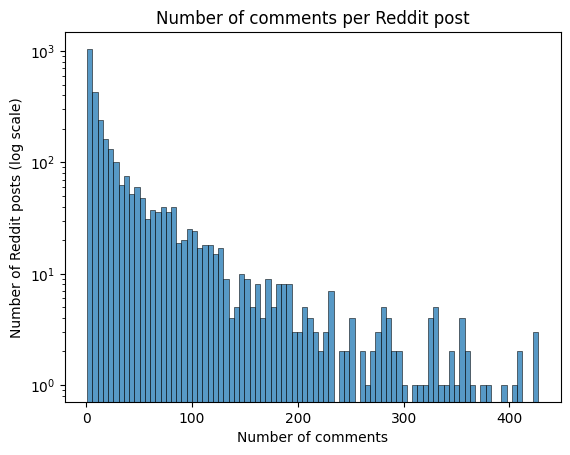

In [30]:
# Get the number of comments per parent submission
submission_comment_counts = com_df_clean.value_counts('parent_submission_id')


print(f'Proportion of Reddit posts with at most 100 comments: '
      f'{len(submission_comment_counts[submission_comment_counts <= 100]) / len(submission_comment_counts): .2%}')

print(f'Proportion of Reddit posts with at most 10 comments: '
      f'{len(submission_comment_counts[submission_comment_counts <= 10]) / len(submission_comment_counts): .2%}')

ax = sns.histplot(submission_comment_counts)
ax.set_title('Number of comments per Reddit post')
ax.set_xlabel('Number of comments')
ax.set_ylabel('Number of Reddit posts (log scale)')
ax.set_yscale('log')
plt.show()

### Figure 2 (To be implemented)